## Safety in The Hague, Netherlands

`Problem Statement`: Pinpointing the exact causes of crime in a city is challenging as contributing factors are highly nuanced and complex. For example, some hypothesize that crime increases as the income inequality increases. Which variables are the best predictors of crime in The Hague? 

`Project Goal`: Inspect variables of interest that may be correlated with crime levels in The Hague, Netherlands and make statistical predictions on crime rates using machine learning. 

In [200]:
# import the necessary libraries
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
import requests
import IPython
from IPython.core.display import HTML
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 200)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format ='retina'

import geopandas as gpd
import palettable as pltt
from seaborn import palplot
import json
import contextily as ctx
from pysal.lib import weights
from pysal.explore import esda
from splot.esda import moran_scatterplot, lisa_cluster, plot_local_autocorrelation
np.random.seed(123)

## Problem Structure

`Hypothesis`: Neighborhoods with higher average disposable income and number of private cars per address will have less offenses and therefore considered safer.
- *High income* means there is high disposable income and average number of private cars. 
- *Safe* means a low number of offenses. 

Key variables
1. All offenses
2. Average number of private cars per address (excluding lease cars)
3. Average disposable income of private households

In [201]:
# read in shape file
hague_shapefile = gpd.read_file('data/neighborhoods.shp')
hague_shapefile.head()

,neighb_cbs,neigb_cijf,geometry
0,Oostduinen,70 Oostduinen,"POLYGON ((4.30290 52.12832, 4.30298 52.12827, ..."
1,Belgisch Park,71 Belgisch Park,"POLYGON ((4.28056 52.11706, 4.28053 52.11706, ..."
2,Westbroekpark,73 Westbroekpark,"POLYGON ((4.29171 52.10745, 4.29181 52.10739, ..."
3,Duttendel,74 Duttendel,"POLYGON ((4.32252 52.10768, 4.32252 52.10766, ..."
4,Nassaubuurt,48 Nassaubuurt,"POLYGON ((4.31943 52.09247, 4.31943 52.09247, ..."


In [202]:
# Set index of shape file
hague_shapefile = hague_shapefile.set_index('neigb_cijf')

Data from [Den Haag Cijfers](https://denhaag.incijfers.nl/jive) and [CBS](https://www.cbs.nl/nl-nl/reeksen/kerncijfers-wijken-en-buurten-2004-2020).

<AxesSubplot:>

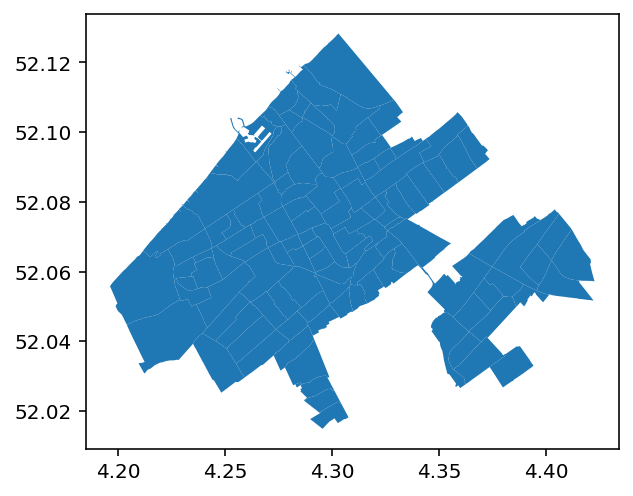

In [203]:
hague_shapefile.plot()

In [204]:
# Read in csv file and set index
hague_keydata = pd.read_csv('data/The Hague key figures.csv')
hague_keydata = hague_keydata.set_index('Buurten')
hague_keydata.head()

,All offences,Average number of private cars per address (excluding lease cars),Average disposable income of private households
Buurten,,,
01 Oud Scheveningen,136.0,0.60,33800.0
02 Vissershaven,392.0,0.62,40200.0
03 Scheveningen Badplaats,421.0,0.58,43700.0
04 Visserijbuurt,197.0,0.54,40500.0
05 v Stolkpark/Schev Bosjes,76.0,0.78,103400.0


In [205]:
# Join data from shape file and hague_keydata
hague = hague_shapefile.merge(hague_keydata, left_index=True, right_index=True)
hague.head()

,neighb_cbs,geometry,All offences,Average number of private cars per address (excluding lease cars),Average disposable income of private households
70 Oostduinen,Oostduinen,"POLYGON ((4.30290 52.12832, 4.30298 52.12827, ...",43.0,x,NaN
71 Belgisch Park,Belgisch Park,"POLYGON ((4.28056 52.11706, 4.28053 52.11706, ...",422.0,0.72,53000.0
73 Westbroekpark,Westbroekpark,"POLYGON ((4.29171 52.10745, 4.29181 52.10739, ...",103.0,0.88,81500.0
74 Duttendel,Duttendel,"POLYGON ((4.32252 52.10768, 4.32252 52.10766, ...",74.0,0.98,128800.0
48 Nassaubuurt,Nassaubuurt,"POLYGON ((4.31943 52.09247, 4.31943 52.09247, ...",104.0,0.77,97100.0


## Exploratory Data Analysis

In [206]:
# Rename columns to something more manageable
hague = hague.rename(columns={'All offences':'offences',
                              'Average number of private cars per address (excluding lease cars)':'avgprivatecars',
                              'Average disposable income of private households':'avgdisposableincome'})
hague.head()

,neighb_cbs,geometry,offences,avgprivatecars,avgdisposableincome
70 Oostduinen,Oostduinen,"POLYGON ((4.30290 52.12832, 4.30298 52.12827, ...",43.0,x,NaN
71 Belgisch Park,Belgisch Park,"POLYGON ((4.28056 52.11706, 4.28053 52.11706, ...",422.0,0.72,53000.0
73 Westbroekpark,Westbroekpark,"POLYGON ((4.29171 52.10745, 4.29181 52.10739, ...",103.0,0.88,81500.0
74 Duttendel,Duttendel,"POLYGON ((4.32252 52.10768, 4.32252 52.10766, ...",74.0,0.98,128800.0
48 Nassaubuurt,Nassaubuurt,"POLYGON ((4.31943 52.09247, 4.31943 52.09247, ...",104.0,0.77,97100.0


In [207]:
# Drop rows with no data
hague_2 = hague.dropna()
hague_2.drop(hague_2.loc[hague_2['avgprivatecars']=='x'].index, inplace=True)
# Convert string to floats
hague_2["avgdisposableincome"] = pd.to_numeric(hague_2["avgdisposableincome"])
hague_2["avgprivatecars"] = pd.to_numeric(hague_2["avgprivatecars"])
hague_2.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 105 entries, 71 Belgisch Park to 121 Rietbuurt
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   neighb_cbs           105 non-null    object  
 1   geometry             105 non-null    geometry
 2   offences             105 non-null    float64 
 3   avgprivatecars       105 non-null    float64 
 4   avgdisposableincome  105 non-null    float64 
dtypes: float64(3), geometry(1), object(1)
memory usage: 4.9+ KB


In [208]:
type(hague_2.avgprivatecars[0])

numpy.float64

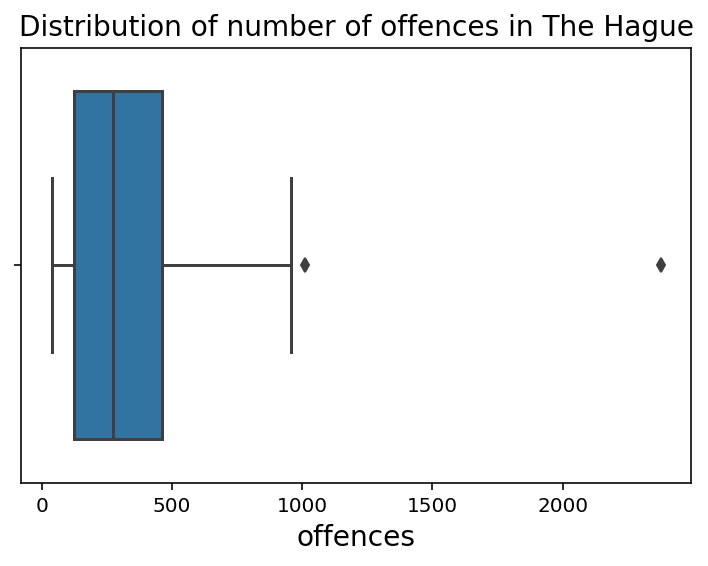

In [209]:
# Boxplot of number of offences
ax = sns.boxplot(x='offences', data=hague_2)
ax.set_ylabel(None);
ax.set_xlabel('offences', fontsize=14);
ax.set_title('Distribution of number of offences in The Hague', fontsize=14);

`Hypothesis`: High income neighborhoods will have offenses in the lower 50th percentile.

In [210]:
# There is one outlier neighborhood with high number of offenses
hague_2.nlargest(5,['offences'])

,neighb_cbs,geometry,offences,avgprivatecars,avgdisposableincome
14 Zuidwal,Zuidwal,"POLYGON ((4.31351 52.07827, 4.31362 52.07822, ...",2376.0,0.29,30000.0
15 Schildersbuurt-West,Schildersbuurt-West,"POLYGON ((4.29696 52.07397, 4.29706 52.07382, ...",1009.0,0.58,28400.0
18 Huygenspark,Huygenspark,"POLYGON ((4.32012 52.07500, 4.32013 52.07493, ...",957.0,0.26,28000.0
11 Kortenbos,Kortenbos,"POLYGON ((4.30902 52.07817, 4.30902 52.07817, ...",946.0,0.39,34500.0
13 Uilebomen,Uilebomen,"POLYGON ((4.32019 52.08136, 4.32039 52.08119, ...",888.0,0.36,38800.0


Zuidwal is the outlier that has the highest number of offences.

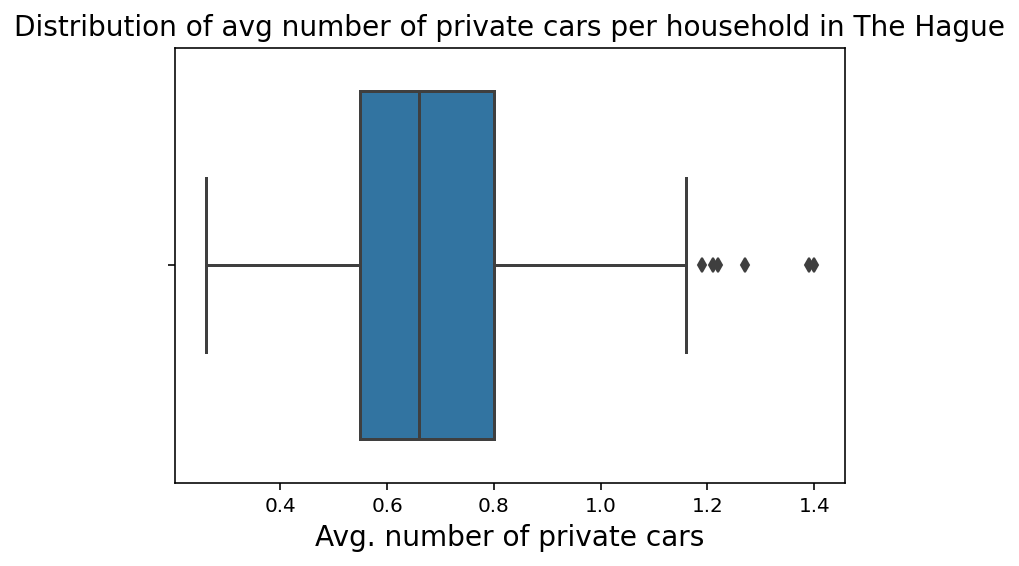

In [211]:
# Boxplot of average number of private cars
ax = sns.boxplot(x=hague_2['avgprivatecars'])
ax.set_ylabel(None);
ax.set_xlabel('Avg. number of private cars', fontsize=14);
ax.set_title('Distribution of avg number of private cars per household in The Hague', fontsize=14);

`Hypothesis`: High income households will have around or more than 1.0 private cars based on the boxplot of average number of private cars.

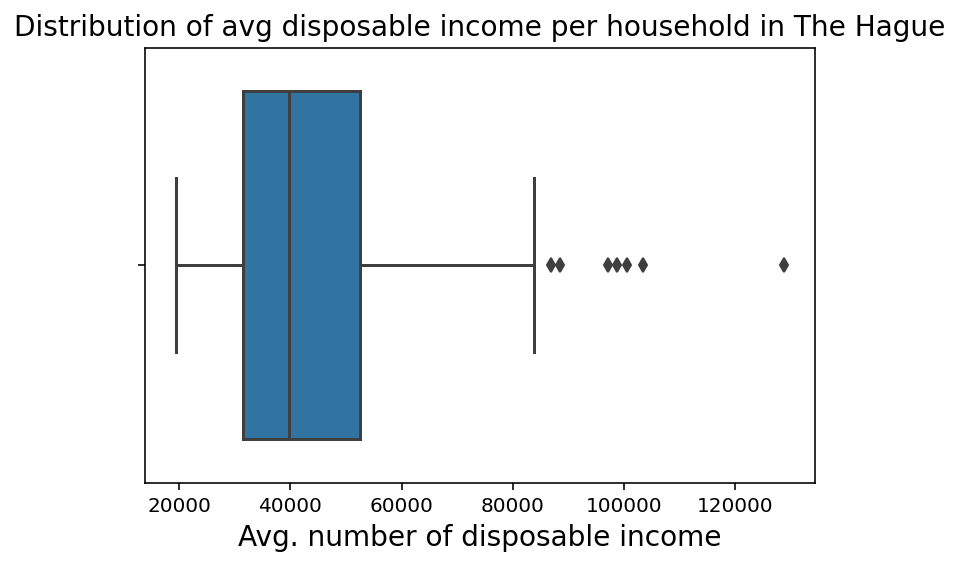

In [212]:
# Boxplot of average disposable income
ax = sns.boxplot(x=hague_2['avgdisposableincome'])
ax.set_ylabel(None);
ax.set_xlabel('Avg. number of disposable income', fontsize=14);
ax.set_title('Distribution of avg disposable income per household in The Hague', fontsize=14);

`Hypothesis`: High income neighborhoods will have higher private car ownership and lower offenses.

In [213]:
# Find the 10 neighborhoods with lowest number of offences
safest = hague_2.nsmallest(10,['offences'])
safest.sort_values(by=['neighb_cbs'], inplace=True)
safest

,neighb_cbs,geometry,offences,avgprivatecars,avgdisposableincome
50 Bloemenbuurt-West,Bloemenbuurt-West,"POLYGON ((4.25365 52.07771, 4.25375 52.07762, ...",60.0,0.84,49800.0
81 Bosjes van Pex,Bosjes van Pex,"POLYGON ((4.25059 52.07645, 4.25074 52.07631, ...",61.0,0.84,56300.0
108 Bosweide,Bosweide,"POLYGON ((4.37400 52.04875, 4.37394 52.04870, ...",65.0,1.39,100500.0
93 Componistenbuurt,Componistenbuurt,"POLYGON ((4.24358 52.06667, 4.24372 52.06648, ...",50.0,0.76,43200.0
120 De Vissen,De Vissen,"POLYGON ((4.41188 52.07213, 4.41192 52.07210, ...",56.0,1.19,54800.0
74 Duttendel,Duttendel,"POLYGON ((4.32252 52.10768, 4.32252 52.10766, ...",74.0,0.98,128800.0
68 Marlot,Marlot,"POLYGON ((4.35883 52.10553, 4.35884 52.10552, ...",38.0,1.11,98700.0
72 Rijslag,Rijslag,"POLYGON ((4.29008 52.10836, 4.29004 52.10833, ...",69.0,0.58,46500.0
75 Uilennest,Uilennest,"POLYGON ((4.34232 52.09748, 4.34233 52.09747, ...",54.0,0.74,51900.0
06 Waldeck-Zuid,Waldeck-Zuid,"POLYGON ((4.23500 52.05866, 4.23523 52.05857, ...",71.0,0.59,32000.0


In [214]:
# Find the top 10 neighborhoods with highest number of avg private cars
cars = hague_2.nlargest(10,['avgprivatecars'])
cars.sort_values(by=['neighb_cbs'], inplace=True)
cars

,neighb_cbs,geometry,offences,avgprivatecars,avgdisposableincome
108 Bosweide,Bosweide,"POLYGON ((4.37400 52.04875, 4.37394 52.04870, ...",65.0,1.39,100500.0
115 De Bras,De Bras,"POLYGON ((4.38118 52.03639, 4.38437 52.03776, ...",138.0,1.21,60200.0
118 De Lanen,De Lanen,"POLYGON ((4.40245 52.06319, 4.40242 52.06314, ...",188.0,1.16,56000.0
119 De Velden,De Velden,"POLYGON ((4.40593 52.07659, 4.40607 52.07649, ...",169.0,1.15,54800.0
120 De Vissen,De Vissen,"POLYGON ((4.41188 52.07213, 4.41192 52.07210, ...",56.0,1.19,54800.0
90 Ockenburgh,Ockenburgh,"POLYGON ((4.22328 52.06641, 4.22334 52.06634, ...",251.0,1.40,88400.0
103 Parkbuurt Oosteinde,Parkbuurt oosteinde,"POLYGON ((4.29789 52.02947, 4.29791 52.02945, ...",79.0,1.27,67600.0
121 Rietbuurt,Rietbuurt,"POLYGON ((4.41539 52.05744, 4.41538 52.05707, ...",84.0,1.14,56100.0
09 Vogelwijk,Vogelwijk,"POLYGON ((4.26475 52.09163, 4.26489 52.09151, ...",247.0,1.11,80600.0
105 Zonne Veld,Zonne Veld,"POLYGON ((4.30419 52.02215, 4.30427 52.02206, ...",121.0,1.22,52300.0


In [215]:
# Find the top 10 neighborhoods with highest avg disposable income
income = hague_2.nlargest(10,['avgdisposableincome'])
income.sort_values(by=['neighb_cbs'], inplace=True)
income

,neighb_cbs,geometry,offences,avgprivatecars,avgdisposableincome
78 Arendsdorp,Arendsdorp,"POLYGON ((4.32329 52.09921, 4.32388 52.09870, ...",75.0,0.74,83700.0
108 Bosweide,Bosweide,"POLYGON ((4.37400 52.04875, 4.37394 52.04870, ...",65.0,1.39,100500.0
74 Duttendel,Duttendel,"POLYGON ((4.32252 52.10768, 4.32252 52.10766, ...",74.0,0.98,128800.0
68 Marlot,Marlot,"POLYGON ((4.35883 52.10553, 4.35884 52.10552, ...",38.0,1.11,98700.0
48 Nassaubuurt,Nassaubuurt,"POLYGON ((4.31943 52.09247, 4.31943 52.09247, ...",104.0,0.77,97100.0
90 Ockenburgh,Ockenburgh,"POLYGON ((4.22328 52.06641, 4.22334 52.06634, ...",251.0,1.40,88400.0
05 v Stolkpark/Schev Bosjes,Van Stolkpark en Scheveningse Bosjes,"POLYGON ((4.28612 52.10404, 4.28637 52.10415, ...",76.0,0.78,103400.0
09 Vogelwijk,Vogelwijk,"POLYGON ((4.26475 52.09163, 4.26489 52.09151, ...",247.0,1.11,80600.0
77 Waalsdorp,Waalsdorp,"POLYGON ((4.32270 52.09912, 4.32271 52.09910, ...",134.0,0.87,86900.0
73 Westbroekpark,Westbroekpark,"POLYGON ((4.29171 52.10745, 4.29181 52.10739, ...",103.0,0.88,81500.0


Looking at the top 10 safest and highest income neighborhoods (based on disposable income and private car ownership), there is little overlap between the safe neighborhoods and highest income neighborhoods. Only the following neighborhoods overlap:
- Bosweide
- De Vissen
- Marlot
- Ockenburgh

This could be due to the fact that people spend their disposable income on other things besides private cars. Also, high income neighborhoods may attract offenses since it is a higher valued area.

## Cloropleths

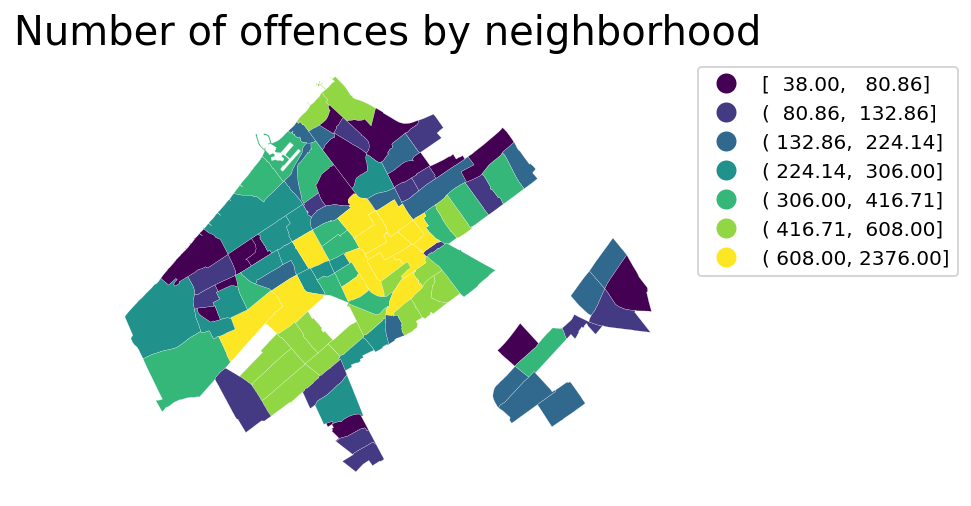

In [216]:
# Number of offences by neighborhood
ax = hague_2.plot(column='offences', scheme='QUANTILES', alpha=1, k=7, \
            cmap=plt.cm.viridis,
            edgecolor='w', linewidth=0.1, legend=True)
# Customizing format of chloropleth
ax.axis('off')
ax.set_title('Number of offences by neighborhood', fontdict={'fontsize': 20})
ax.get_legend().set_bbox_to_anchor((1.5,1))

In the choropleth above, the darker colors show the safest neighborhoods. This can be compared to the chloropleths of the other variables. 

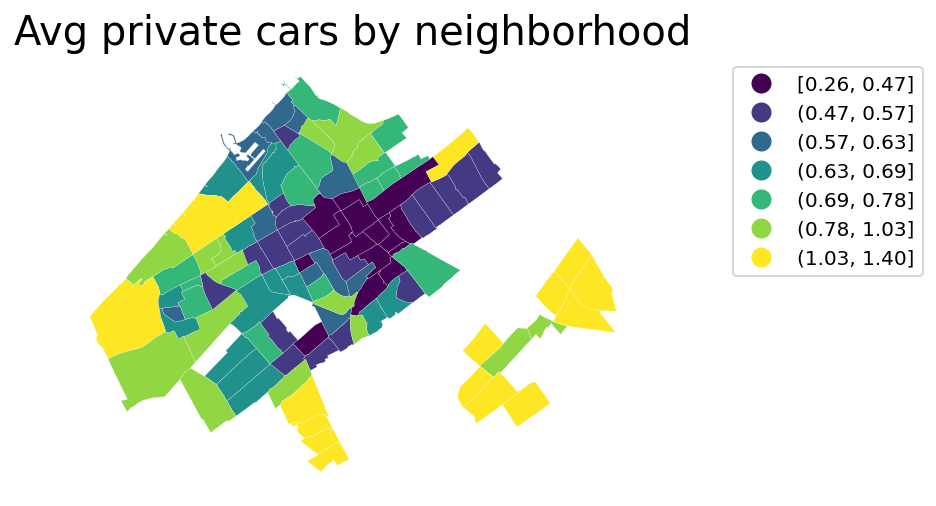

In [217]:
# Avg private cars by neighborhood
ax = hague_2.plot(column='avgprivatecars', scheme='QUANTILES', alpha=1, k=7, \
            cmap=plt.cm.viridis,
            edgecolor='w', linewidth=0.1, legend=True)
# Customizing format of chloropleth
ax.axis('off')
ax.set_title('Avg private cars by neighborhood', fontdict={'fontsize': 20})
ax.get_legend().set_bbox_to_anchor((1.5,1))

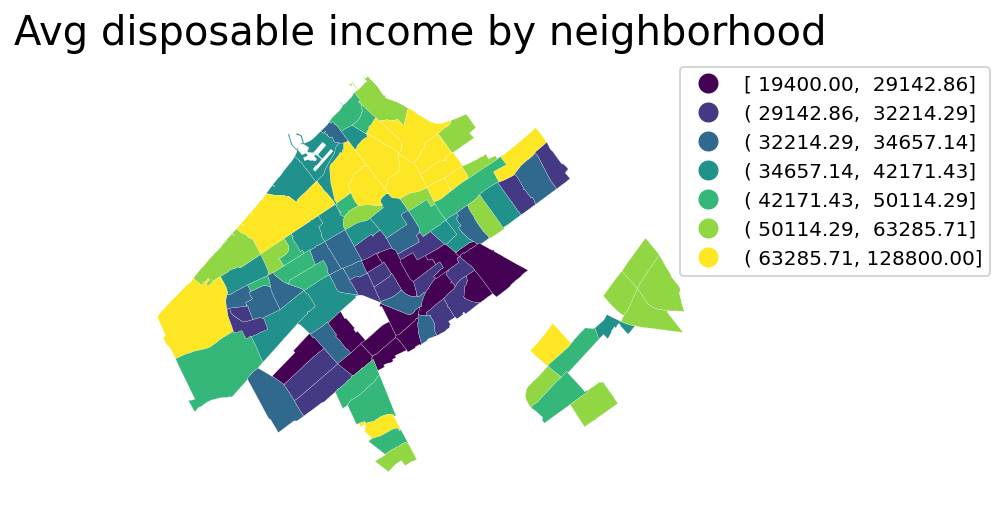

In [218]:
# Avg disposable income by neighborhood
ax = hague_2.plot(column='avgdisposableincome', scheme='QUANTILES', alpha=1, k=7, \
            cmap=plt.cm.viridis,
            edgecolor='w', linewidth=0.1, legend=True)
# Customizing format of chloropleth
ax.axis('off')
ax.set_title('Avg disposable income by neighborhood', fontdict={'fontsize': 20})
ax.get_legend().set_bbox_to_anchor((1.5,1))

The highest income neighborhoods are closer to the coast.

## Spatial Analysis

In [219]:
%time w = weights.Queen.from_dataframe(hague_2, idVariable='neighb_cbs')

Wall time: 301 ms


In [220]:
# Check the neighbors of the highest income neighborhood, Duttendel
w['Duttendel']

{'Westbroekpark': 1.0,
 'Waalsdorp': 1.0,
 'Duinzigt': 1.0,
 'Van Stolkpark en Scheveningse Bosjes': 1.0,
 'Belgisch Park': 1.0,
 'Archipelbuurt': 1.0}

In [221]:
# Row standardize the matrix
w.transform = 'R'
w['Duttendel']

{'Westbroekpark': 0.16666666666666666,
 'Waalsdorp': 0.16666666666666666,
 'Duinzigt': 0.16666666666666666,
 'Van Stolkpark en Scheveningse Bosjes': 0.16666666666666666,
 'Belgisch Park': 0.16666666666666666,
 'Archipelbuurt': 0.16666666666666666}

In [222]:
# Spatial lag
hague_2['w_avgdisposableincome'] = weights.lag_spatial(w, hague_2['avgdisposableincome'])
hague_2.sort_values(by=['avgdisposableincome'], ascending=False, inplace=True)
# Checking the value for Duttendel
hague_3 = hague_2.set_index('neighb_cbs')
duttendel = hague_3.loc[w.neighbors['Duttendel'], 'avgdisposableincome']
duttendel

neighb_cbs
Westbroekpark                            81500.0
Waalsdorp                                86900.0
Duinzigt                                 61100.0
Van Stolkpark en Scheveningse Bosjes    103400.0
Belgisch Park                            53000.0
Archipelbuurt                            74800.0
Name: avgdisposableincome, dtype: float64

The above table shows the average disposable income of the neighbors of the highest income neighborhood in The Hague.

In [223]:
duttendel.mean()

76783.33333333333

The mean average disposable income of the neighbors of Duttendel is 76,783.

In [224]:
# Standarisizing data
hague_2['std_avgdisposableincome'] = (hague_2['avgdisposableincome'] - hague_2['avgdisposableincome'].mean()) / hague_2['avgdisposableincome'].std()
hague_2['w_std_avgdisposableincome'] = weights.lag_spatial(w, hague_2['std_avgdisposableincome'])
hague_2.head(3)

,neighb_cbs,geometry,offences,avgprivatecars,avgdisposableincome,w_avgdisposableincome,std_avgdisposableincome,w_std_avgdisposableincome
74 Duttendel,Duttendel,"POLYGON ((4.32252 52.10768, 4.32252 52.10766, ...",74.0,0.98,128800.0,37650.000000,4.077847,-0.217795
05 v Stolkpark/Schev Bosjes,Van Stolkpark en Scheveningse Bosjes,"POLYGON ((4.28612 52.10404, 4.28637 52.10415, ...",76.0,0.78,103400.0,42300.000000,2.834436,0.283975
108 Bosweide,Bosweide,"POLYGON ((4.37400 52.04875, 4.37394 52.04870, ...",65.0,1.39,100500.0,45583.333333,2.692472,-0.431965


Because the average disposable income of Duttendel is an outlier, the mean average disposable income of neighbors is much lower than itself. It has a relatively high average number of private cars and low offenses which is consistent with my hypothesis.

## Local Spatial Correlation

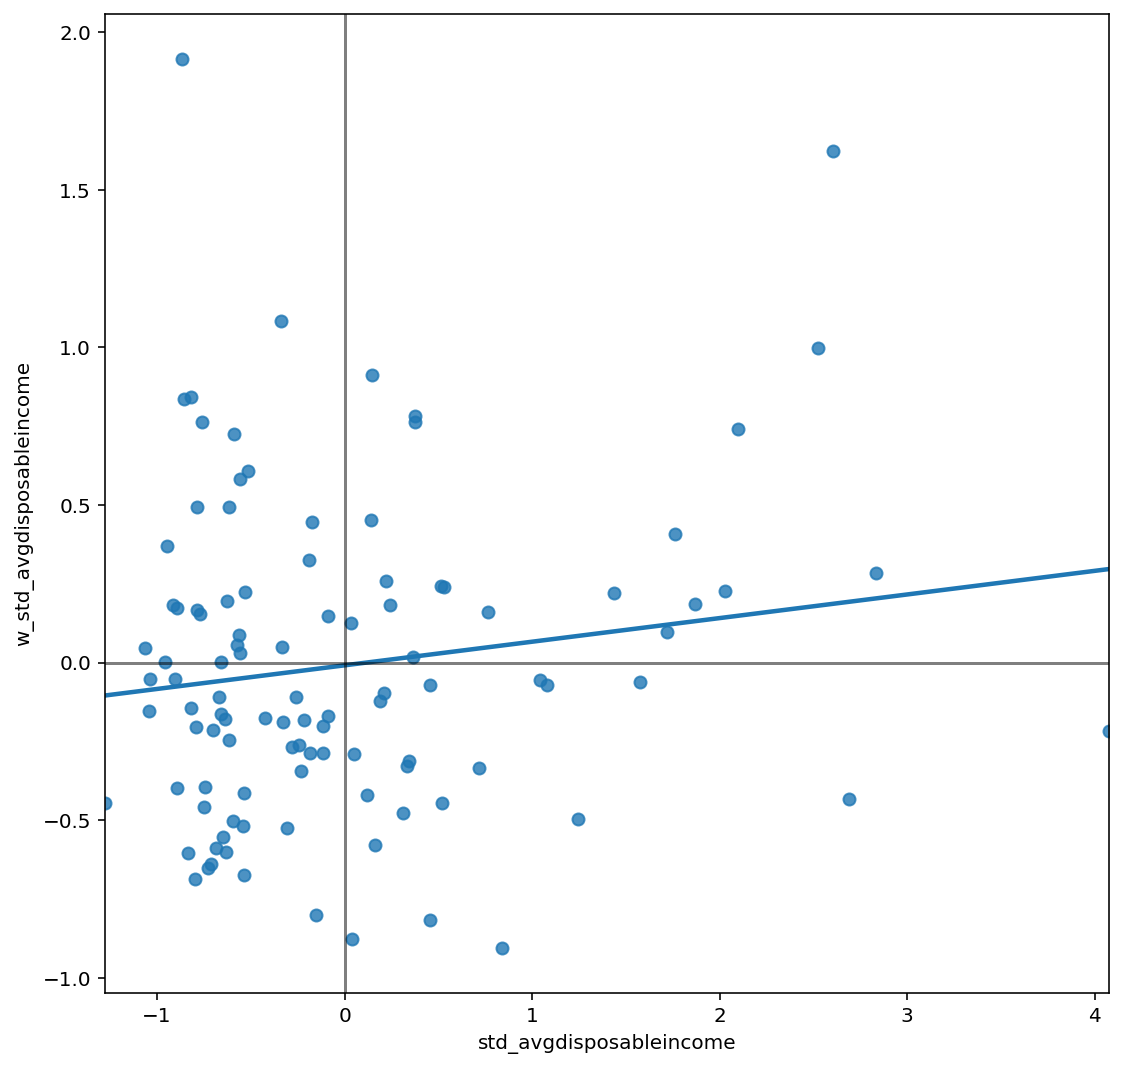

In [225]:
# Setup Moran Plot for average disposable income
f, ax = plt.subplots(1, figsize=(9,9))
sns.regplot(x='std_avgdisposableincome', y='w_std_avgdisposableincome', data=hague_2, ci=None)
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
plt.show()

The trendline is positive though not that steep which means that higher income neighborhoods tend to be located close to each other. Because the line is not that steep, it means that there are neighborhoods of high income that are close to those of much lower income. 

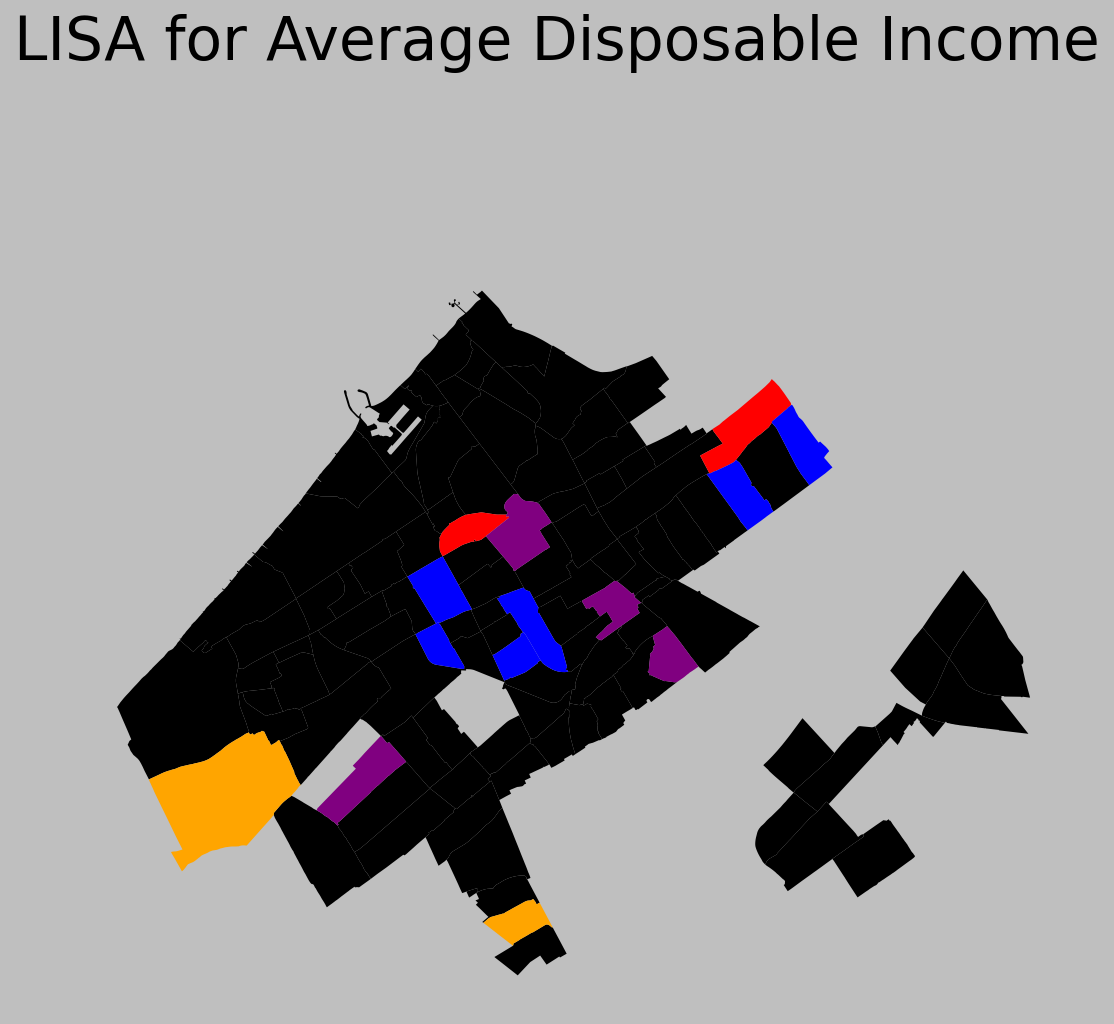

In [226]:
# Calculate LISAs and plot them
lisa = esda.Moran_Local(hague_2['avgdisposableincome'], w)
hague_2['significant'] = lisa.p_sim < 0.05
hague_2['quadrant'] = lisa.q

# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))

# Plot insignificant clusters
ns = hague_2.loc[hague_2['significant']==False, 'geometry']
ns.plot(ax=ax, color='k')

# Plot HH clusters
hh = hague_2.loc[(hague_2['quadrant']==1) & (hague_2['significant']==True), 'geometry']
hh.plot(ax=ax, color='red')

# Plot LL clusters
ll = hague_2.loc[(hague_2['quadrant']==3) & (hague_2['significant']==True), 'geometry']
ll.plot(ax=ax, color='blue')

# Plot LH clusters
lh = hague_2.loc[(hague_2['quadrant']==2) & (hague_2['significant']==True), 'geometry']
lh.plot(ax=ax, color='purple')

# Plot HL clusters
hl = hague_2.loc[(hague_2['quadrant']==4) & (hague_2['significant']==True), 'geometry']
hl.plot(ax=ax, color='orange')

# Style and draw
f.suptitle('LISA for Average Disposable Income', size=30)
f.set_facecolor('0.75')
ax.set_axis_off()
plt.show()

In red are the neighborhoods that are relatively high income and also surrounded by other high income neighborhoods.

In orange are neighborhoods that are relatively high income but surrounded by lower income neighborhoods.

In purple are neigborhoods that are relatively low income but surrounded by higher income neighborhoods. 

(<Figure size 1080x288 with 3 Axes>,
 array([<AxesSubplot:title={'center':'Moran Local Scatterplot'}, xlabel='Attribute', ylabel='Spatial Lag'>,
        <AxesSubplot:>, <AxesSubplot:>], dtype=object))

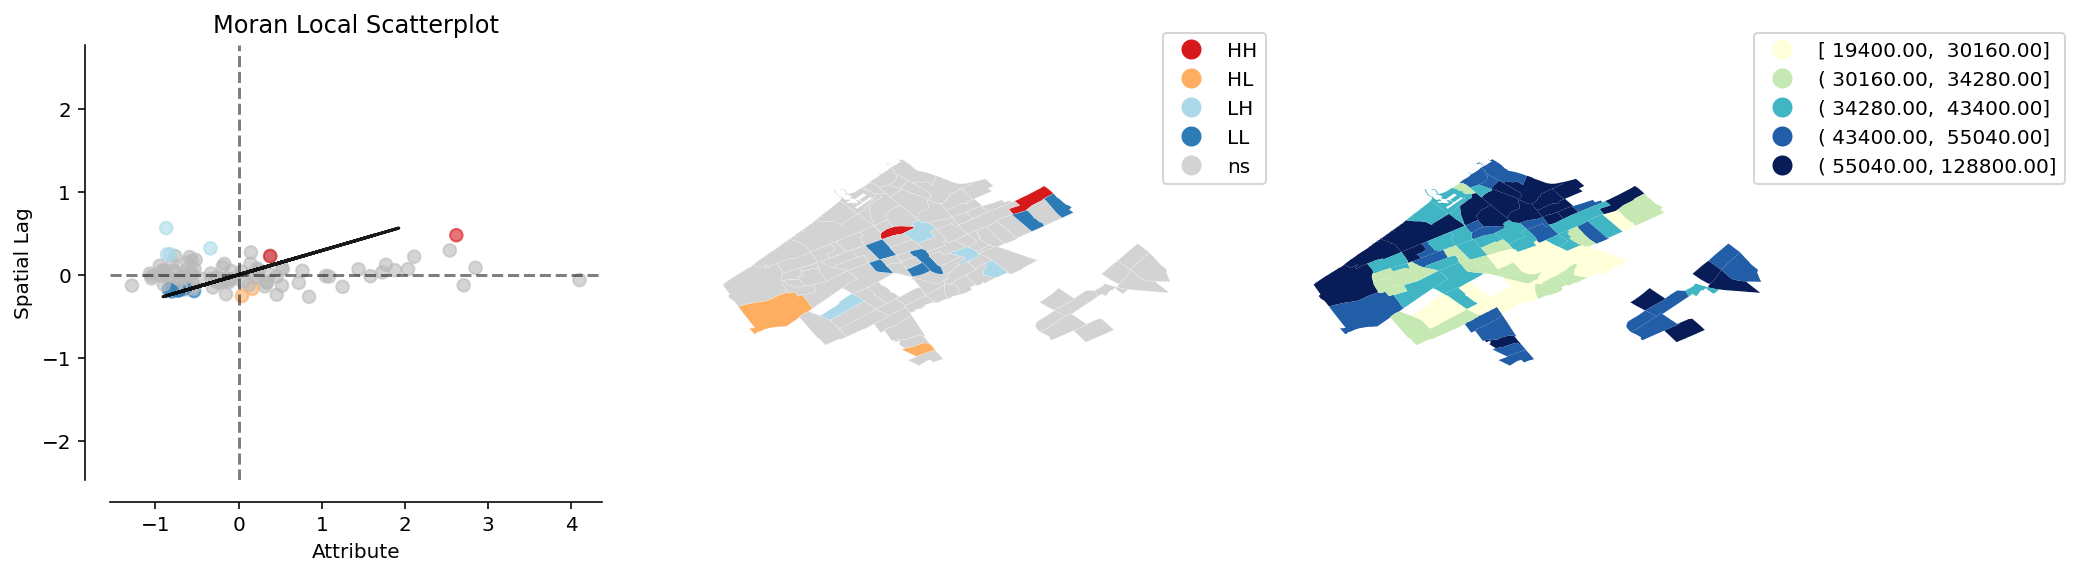

In [227]:
plot_local_autocorrelation(lisa, hague_2, 'avgdisposableincome')

## Comparing across three variables

In [228]:
# Normalizing the data to compare across the three variables
hague_2['offencesnorm'] = ((hague_2["offences"]-hague_2["offences"].min())/(hague_2["offences"].max()-hague_2["offences"].min()))*100
hague_2['avgprivatecarsnorm'] = ((hague_2["avgprivatecars"]-hague_2["avgprivatecars"].min())/(hague_2["avgprivatecars"].max()-hague_2["avgprivatecars"].min()))*100
hague_2['avgdisposableincomenorm'] = ((hague_2["avgdisposableincome"]-hague_2["avgdisposableincome"].min())/(hague_2["avgdisposableincome"].max()-hague_2["avgdisposableincome"].min()))*100
hague_2.head(2)

,neighb_cbs,geometry,offences,avgprivatecars,avgdisposableincome,w_avgdisposableincome,std_avgdisposableincome,w_std_avgdisposableincome,significant,quadrant,offencesnorm,avgprivatecarsnorm,avgdisposableincomenorm
74 Duttendel,Duttendel,"POLYGON ((4.32252 52.10768, 4.32252 52.10766, ...",74.0,0.98,128800.0,37650.0,4.077847,-0.217795,False,4,1.539778,63.157895,100.00000
05 v Stolkpark/Schev Bosjes,Van Stolkpark en Scheveningse Bosjes,"POLYGON ((4.28612 52.10404, 4.28637 52.10415, ...",76.0,0.78,103400.0,42300.0,2.834436,0.283975,False,1,1.625321,45.614035,76.78245


In [229]:
# Focusing only on the four neighborhoods with high correlation between safety and high income
neighborhoods = hague_2.drop(index=hague_2.index.difference(['108 Bosweide', '120 De Vissen', '68 Marlot', '90 Ockenburgh']))
neighborhoods

,neighb_cbs,geometry,offences,avgprivatecars,avgdisposableincome,w_avgdisposableincome,std_avgdisposableincome,w_std_avgdisposableincome,significant,quadrant,offencesnorm,avgprivatecarsnorm,avgdisposableincomenorm
108 Bosweide,Bosweide,"POLYGON ((4.37400 52.04875, 4.37394 52.04870, ...",65.0,1.39,100500.0,45583.333333,2.692472,-0.431965,False,4,1.154833,99.122807,74.131627
68 Marlot,Marlot,"POLYGON ((4.35883 52.10553, 4.35884 52.10552, ...",38.0,1.11,98700.0,32575.000000,2.604356,1.622029,True,1,0.000000,74.561404,72.486289
90 Ockenburgh,Ockenburgh,"POLYGON ((4.22328 52.06641, 4.22334 52.06634, ...",251.0,1.40,88400.0,31650.000000,2.100138,0.742177,False,1,9.110351,100.000000,63.071298
120 De Vissen,De Vissen,"POLYGON ((4.41188 52.07213, 4.41192 52.07210, ...",56.0,1.19,54800.0,36233.333333,0.455311,-0.817472,False,4,0.769889,81.578947,32.358318


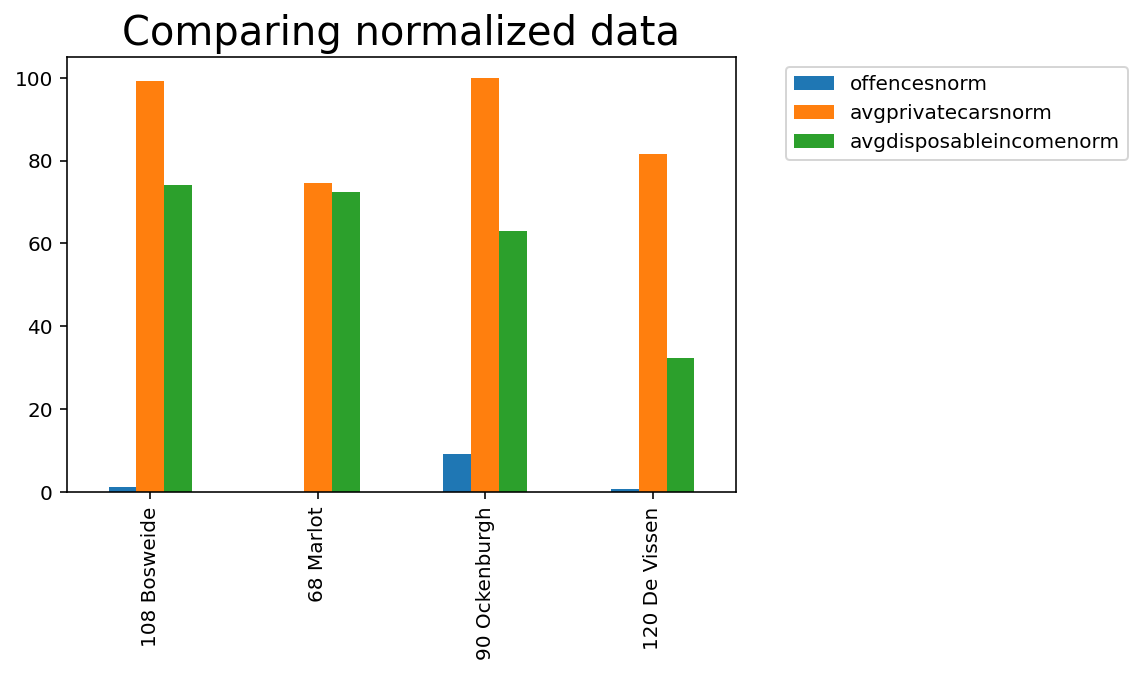

In [230]:
ax = neighborhoods[['offencesnorm','avgprivatecarsnorm','avgdisposableincomenorm']].plot(kind='bar')
ax.set_title('Comparing normalized data', fontdict={'fontsize': 20})
ax.get_legend().set_bbox_to_anchor((1.6,1))

Using the normalized graph, one can see that those with high avg private cars (within the 75th percentile) typically have high average disposable income (within 60th percentile except for De Vissen). I will now compare the data across the top safest and highest income neighborhoods.

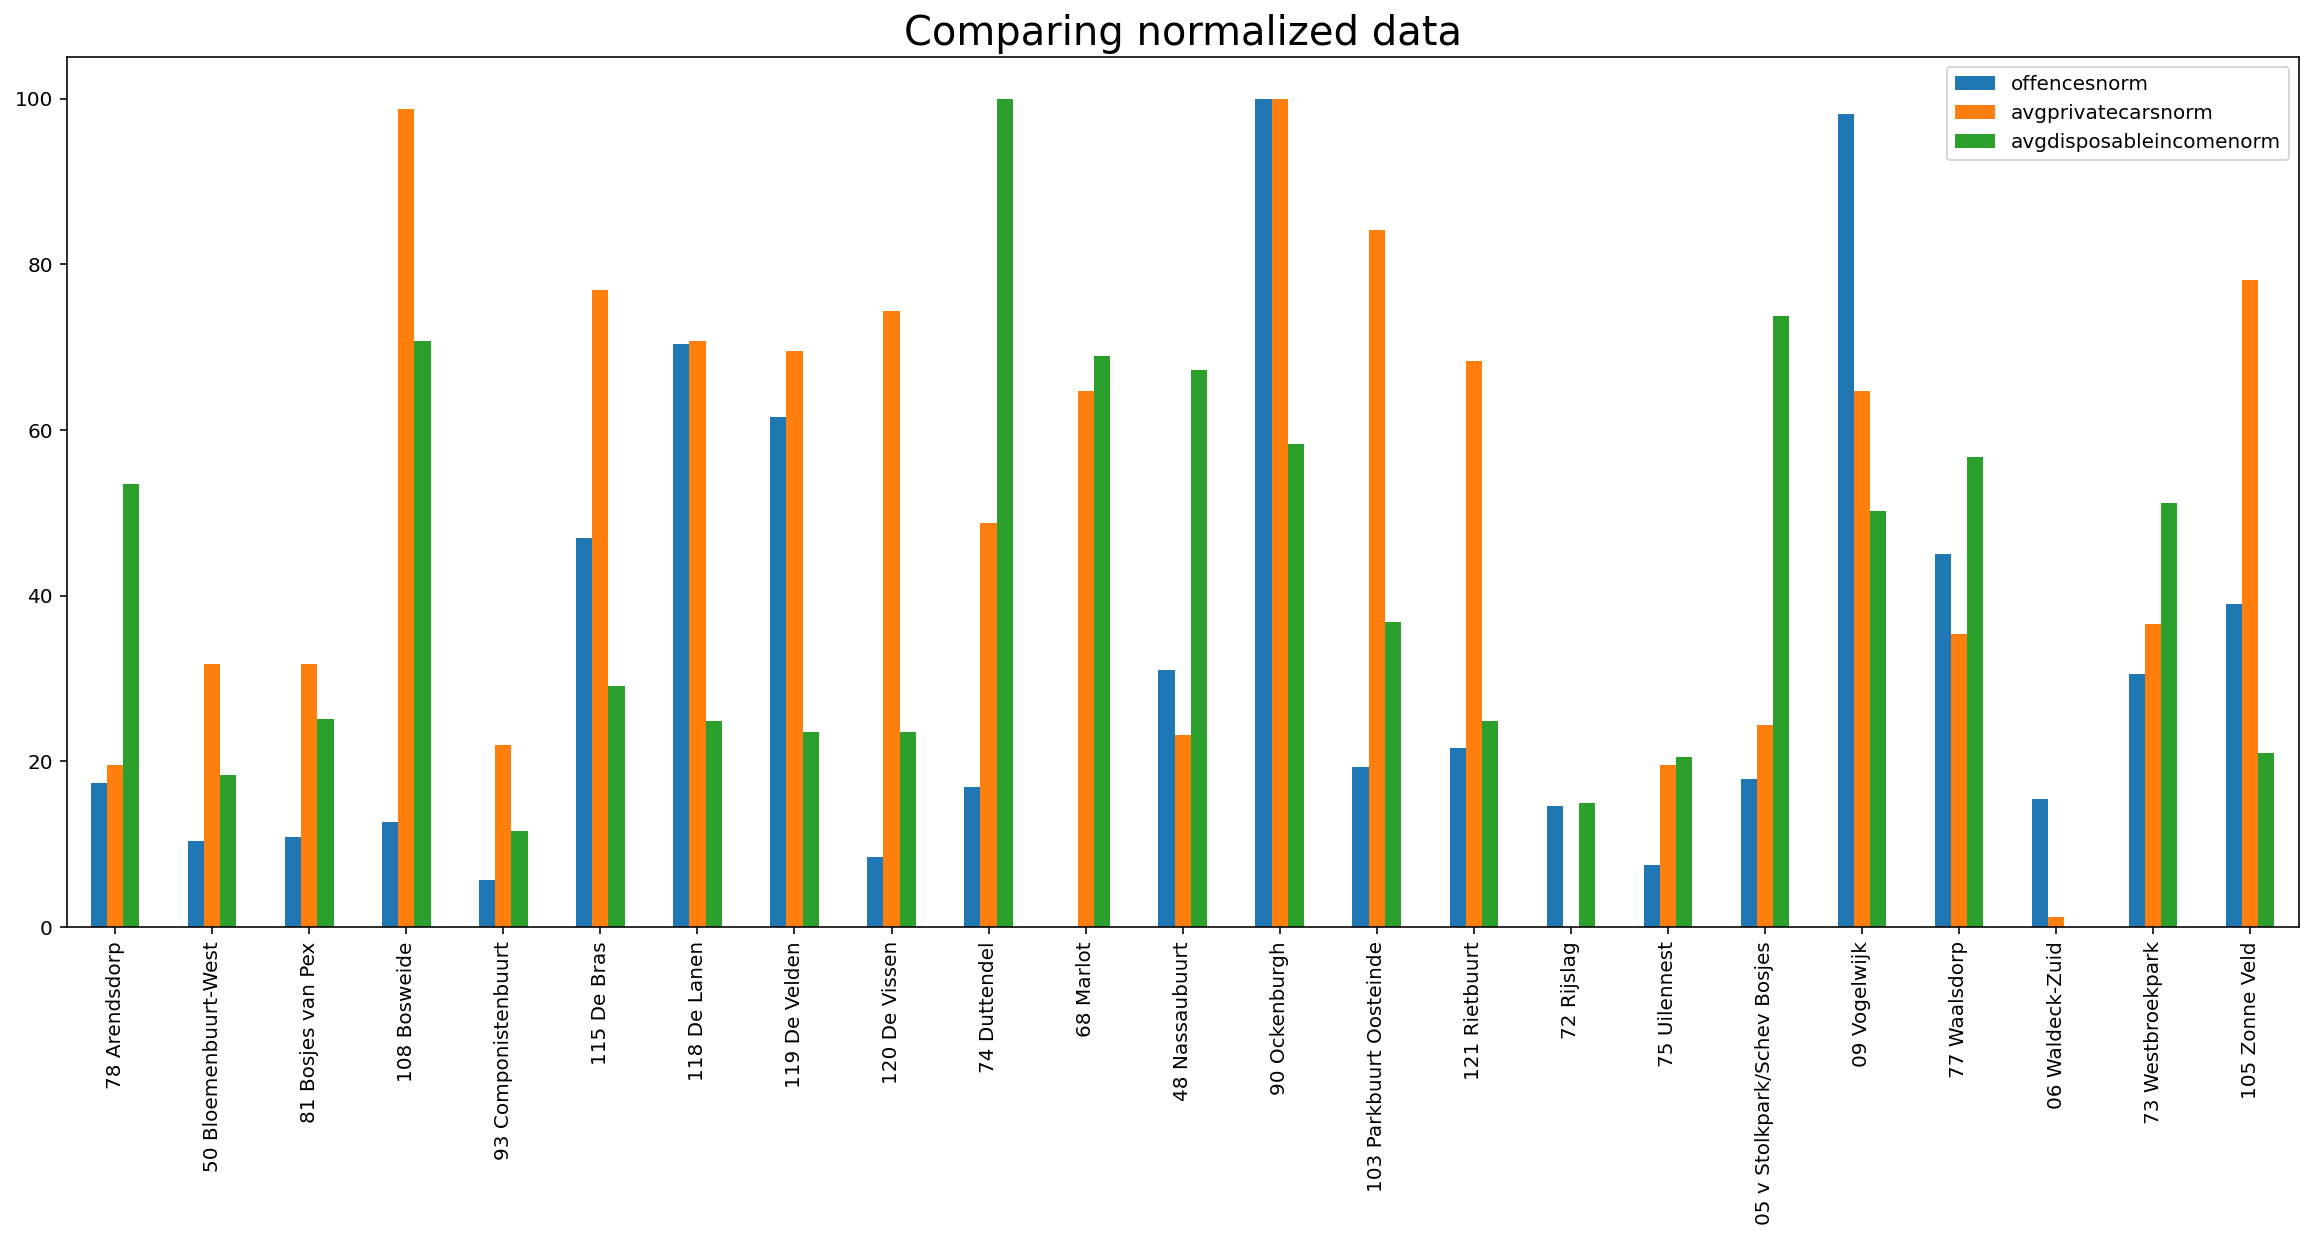

In [231]:
safe_n_rich = pd.concat([safest, cars, income])
safe_n_rich = safe_n_rich.drop_duplicates()

# Normalize data
safe_n_rich['offencesnorm'] = ((safe_n_rich["offences"]-safe_n_rich["offences"].min())/(safe_n_rich["offences"].max()-safe_n_rich["offences"].min()))*100
safe_n_rich['avgprivatecarsnorm'] = ((safe_n_rich["avgprivatecars"]-safe_n_rich["avgprivatecars"].min())/(safe_n_rich["avgprivatecars"].max()-safe_n_rich["avgprivatecars"].min()))*100
safe_n_rich['avgdisposableincomenorm'] = ((hague_2["avgdisposableincome"]-safe_n_rich["avgdisposableincome"].min())/(safe_n_rich["avgdisposableincome"].max()-safe_n_rich["avgdisposableincome"].min()))*100
safe_n_rich.sort_values(by=['neighb_cbs'], inplace=True)

# Plot the figure
ax = safe_n_rich[['offencesnorm','avgprivatecarsnorm','avgdisposableincomenorm']].plot(kind='bar', figsize=(20,8))
ax.set_title('Comparing normalized data', fontdict={'fontsize': 20})
ax.get_legend().set_bbox_to_anchor((1,1))

There are some exceptions that prove my hypothesis wrong. For example, De Lanen, De Velden, Ockenburgh, and Vogelwijk have high number of offences even though they have high number of average private cars and also relatively high disposable income. Similarly, there are high income neighborhoods with relatively fewer number of private cars - Duttendel, Stolkpark, Arendsdorp, Rijslag - and lower disposable income neighborhoods with high number of private cars - Zonne Veld, Parkbuurt Oosteinde, Rietbuurt, De Vissen, De Velden, De Lanen, De Bras. 

In [232]:
# Find correlation between avg disposable income and private cars
correlation = safe_n_rich['avgdisposableincome'].corr(safe_n_rich['avgprivatecars'])
print(correlation)

0.21341070486196112


There is low correlation between average disposable income and average private cars.

In [233]:
# Find correlation between avg disposable income and offences
correlation = safe_n_rich['avgdisposableincome'].corr(safe_n_rich['offences'])
print(correlation)

0.08538500772344323


The correlation between average disposable income and offences is close to zero which means there is no linear relationship. There is not as much of a correlation between avg disposable income and offences as I had initially hypothesized.

In [234]:
# Find correlation between avg private cars and offences
correlation = safe_n_rich['avgprivatecars'].corr(safe_n_rich['offences'])
print(correlation)

0.45111659121263814


The highest correlation is between average private cars and offences. This might be due to the fact that private cars attract offenses like stealing.